<a href="https://colab.research.google.com/github/gmedrano/AIE4/blob/main/%5Bworking_file%5D_Inference_Optimization_Through_Quantization_Strategies_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference Optimization Through Quantization Strategies

We'll take a look at how effective post-training quantization strategies can be when it comes to decreasing inference latency.



In [1]:
!pip install -qU transformers autoawq accelerate openai huggingface-hub peft torch==2.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
from getpass import getpass

os.environ["HF_TOKEN"] = getpass("HF_TOKEN")

HF_TOKEN··········


In [3]:
from huggingface_hub import notebook_login

notebook_login()

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Simple Benchmark: `BitsAndBytes` vs. GPTQ vs. AWQ

We've learned, at this point, about BitsAndBytes and how much memory footprint we can save using Tim Dettmer's libraries. However, we've always had to include a small caveat:

> BitsAndBytes does not improve inference performance, in fact, there is a small inference penalty for using it.

Enter: GPTQ & AWQ!

By taking advantage of a number of innovative techniques, GPTQ & AWQ are able to provide inference-time benefits *without* sacrificing as much accuracy/etc. as BitsAndBytes.

There is one distinct *disadvantage* to GPTQ and AWQ, which is that they are post-training Quantization strategies - and so are not useful while fine-tuning/training models.

Let's take a look at the inference-time benefits by comparing three Hugging Face Inference Endpoints, each running the model in GPTQ/AWQ/BNBs respectively, to see how they perform.



> NOTE: The following cell will take a while to install - please move on to Activity #1 while you wait for the installation to complete.

In [4]:
!pip install -qU gptqmodel --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.28.3 which is incompatible.
google-cloud-firestore 2.16.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.28.3 which is incompatible.
tensorboard 2.17.0 requires protobuf!=4.24.0,<5.0.0,>=3.19.6, but you have protobuf 5.28.3 which is incompatible.
tensorflow 2.17.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.28.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<

#### 🏗️ Activity #1:

You must spin up a total of 3 inference endpoints:

1. Regular [`meta-llama/Llama-3.1-8B-Instruct`](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct) (or NousResearch variant if you don't have access to Meta's weights)
2. [Hugging Quants
Meta-Llama-3.1-8B-Instruct-GPTQ-INT4](https://huggingface.co/hugging-quants/Meta-Llama-3.1-8B-Instruct-GPTQ-INT4) weights.
3. [Hugging Quants
Meta-Llama-3.1-8B-Instruct-AWQ-INT4](https://huggingface.co/hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4) weights.

> NOTE: You can spin these up all at once, or serially, depending on your preference.

### Big Wall of Test Strings

~100 test strings to do some generations with.

#### Wall of Strings

In [5]:
test_sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "I can't believe I ate the whole thing.",
    "To be or not to be, that is the question.",
    "All you need is love.",
    "Houston, we have a problem.",
    "Elementary, my dear Watson.",
    "Life is like a box of chocolates.",
    "May the Force be with you.",
    "E.T. phone home.",
    "There's no place like home.",
    "I'll be back.",
    "Here's looking at you, kid.",
    "You talkin' to me?",
    "I'm going to make him an offer he can't refuse.",
    "You can't handle the truth!",
    "I see dead people.",
    "Say hello to my little friend!",
    "You had me at hello.",
    "I'm the king of the world!",
    "I'll have what she's having.",
    "Keep your friends close, but your enemies closer.",
    "I feel the need... the need for speed!",
    "You're gonna need a bigger boat.",
    "Nobody puts Baby in a corner.",
    "I'm walking here! I'm walking here!",
    "You complete me.",
    "I drink your milkshake!",
    "Why so serious?",
    "I'm not bad. I'm just drawn that way.",
    "You can't sit with us!",
    "I volunteer as tribute!",
    "Winter is coming.",
    "I solemnly swear that I am up to no good.",
    "Live long and prosper.",
    "I'm the one who knocks.",
    "You know nothing, Jon Snow.",
    "I am Groot.",
    "Not all those who wander are lost.",
    "The night is dark and full of terrors.",
    "A Lannister always pays his debts.",
    "Bazinga!",
    "How you doin'?",
    "Wubba lubba dub dub!",
    "I am the danger.",
    "Clear eyes, full hearts, can't lose.",
    "Doh!",
    "Yada, yada, yada.",
    "How you doin'?",
    "Suit up!",
    "That's what she said.",
    "Pivot! Pivot! Pivot!",
    "I'm not a regular mom, I'm a cool mom.",
    "You're killing me, Smalls!",
    "I am serious. And don't call me Shirley.",
    "I love the smell of napalm in the morning.",
    "I'm not arguing, I'm just explaining why I'm right.",
    "I'm not bossy, I just have better ideas.",
    "I'm not saying it was aliens, but it was aliens.",
    "I'm not saying I'm Batman, I'm just saying no one has ever seen me and Batman in the same room together.",
    "I'm not saying I'm Wonder Woman, I'm just saying no one has ever seen me and Wonder Woman in the same room together.",
    "I'm not saying I'm Superman, I'm just saying no one has ever seen me and Superman in the same room together.",
    "I'm not saying I'm Spider-Man, I'm just saying no one has ever seen me and Spider-Man in the same room together.",
    "I'm not saying I'm Iron Man, I'm just saying no one has ever seen me and Iron Man in the same room together.",
    "I'm not saying I'm Captain America, I'm just saying no one has ever seen me and Captain America in the same room together.",
    "I'm not saying I'm Thor, I'm just saying no one has ever seen me and Thor in the same room together.",
    "I'm not saying I'm the Hulk, I'm just saying no one has ever seen me and the Hulk in the same room together.",
    "I'm not saying I'm Black Widow, I'm just saying no one has ever seen me and Black Widow in the same room together.",
    "I'm not saying I'm Hawkeye, I'm just saying no one has ever seen me and Hawkeye in the same room together.",
    "The cake is a lie.",
    "All your base are belong to us.",
    "It's dangerous to go alone! Take this.",
    "Do a barrel roll!",
    "The princess is in another castle.",
    "You have died of dysentery.",
    "Snake? Snake? Snaaaake!",
    "War. War never changes.",
    "Would you kindly?",
    "Finish him!",
    "Get over here!",
    "Hadouken!",
    "Fatality!",
    "Leeeeeeeroy Jenkins!",
    "Stay a while and listen!",
    "You must construct additional pylons.",
    "It's super effective!",
    "A wild Pikachu appeared!",
    "Gotta catch 'em all!",
    "Do, or do not. There is no try.",
    "These aren't the droids you're looking for.",
    "I find your lack of faith disturbing.",
    "Never tell me the odds.",
    "I've got a bad feeling about this.",
    "Use the Force, Luke.",
    "The needs of the many outweigh the needs of the few.",
    "Beam me up, Scotty.",
    "Resistance is futile.",
    "Make it so.",
    "Space: the final frontier.",
    "I'm a doctor, not a bricklayer!",
    "Fascinating.",
    "Engage.",
    "Today is a good day to die!",
    "These are the voyages of the starship Enterprise."
]

### Inference Test Helper Function

We'll create a function that tests a few key inference related metrics:

1. Time to First Token (TTFT): How long does it take before our endpoint starts returning tokens, TTFT is key in creating applications that *feel* responsive due to responses from LLMs typically being streamed to users as tokens are generated.
2. Inter-Token Latency (ITL): Inter-Token Latency talks about the amount of time between tokens being generated. Lower ITL helps the response come through fast enough to keep up with typical reading speeds.
3. Tokens Per Second (TPS): A classic metric that simply indicates how many Tokens are produced per second.

Let's create this function below - and then use it evaluate our AWQ endpoint and our BNB endpoint.

In [6]:
import os
import time
from openai import OpenAI
from typing import List, Dict
from tqdm import tqdm

def measure_endpoint_performance(endpoint_url: str, sentences: List[str]) -> Dict[str, float]:
    client = OpenAI(
        base_url=endpoint_url,
        api_key=os.environ["HF_TOKEN"]
    )

    total_time = 0
    total_first_token_time = 0
    total_tokens = 0
    total_inter_token_time = 0
    total_inter_token_intervals = 0

    for sentence in tqdm(sentences):
        start_time = time.time()
        first_token_received = False
        tokens_received = 0
        last_token_time = start_time

        chat_completion = client.chat.completions.create(
            model="tgi",
            messages=[
                {
                    "role": "user",
                    "content": sentence
                }
            ],
            stream=True,
            max_tokens=20
        )

        for message in chat_completion:
            current_time = time.time()
            if not first_token_received:
                first_token_time = current_time - start_time
                total_first_token_time += first_token_time
                first_token_received = True
            else:
                inter_token_time = current_time - last_token_time
                total_inter_token_time += inter_token_time
                total_inter_token_intervals += 1

            content = message.choices[0].delta.content
            if content:
                tokens_received += 1
                last_token_time = current_time

        request_time = time.time() - start_time
        total_time += request_time
        total_tokens += tokens_received

    num_sentences = len(sentences)
    average_time = total_time / num_sentences
    average_first_token_time = total_first_token_time / num_sentences
    average_tokens_per_second = total_tokens / total_time
    average_inter_token_latency = total_inter_token_time / total_inter_token_intervals if total_inter_token_intervals > 0 else 0

    return {
        "average_request_time": average_time,
        "average_time_to_first_token": average_first_token_time,
        "average_tokens_per_second": average_tokens_per_second,
        "average_inter_token_latency": average_inter_token_latency
    }

### Bits and Bytes Endpoint Evaluation

First, let's baseline with [Llama 3.1 8B Instruct](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct) powered by BitsAndBytes quantization through TGI.

In [7]:
bitsandbytes_endpoint_url = "https://qf1v0qj8261iceib.us-east-1.aws.endpoints.huggingface.cloud" + "/v1/"

In [8]:
results = measure_endpoint_performance(bitsandbytes_endpoint_url, test_sentences)
print("\nResults:")
for key, value in results.items():
    print(f"{key}: {value:.2f}")

100%|██████████| 103/103 [02:06<00:00,  1.22s/it]


Results:
average_request_time: 1.22
average_time_to_first_token: 0.13
average_tokens_per_second: 15.53
average_inter_token_latency: 0.06


### GPTQ Evaluation

We'll be using the [Hugging Quants
Meta-Llama-3.1-8B-Instruct-GPTQ-INT4](https://huggingface.co/hugging-quants/Meta-Llama-3.1-8B-Instruct-GPTQ-INT4) model as our GPTQ test model.

Given what we've learned about GPTQ - this endpoint should outperform our naive BitsAndBytes quantized endpoint.

#### GPTQ: Under the Hood

The basic outline of what's happening in GPTQ is as follows:

1. Start with a pre-trained language model
2. For each layer:
  - Compute an approximation of the layer's Hessian matrix
  - Quantize weights column-by-column
  - After each column, update remaining weights to compensate
3. Use special tricks to make this efficient:
  - Quantize in fixed order instead of greedy order
  - Process weights in batches
  - Use Cholesky decomposition for numerical stability
4. Result: Compressed model that can run much faster

#### Hessian Matrix:

Okay, so that makes sense - but there's a question: What is the layer's "Hessian matrix"?

In essence, we can think of the layer's "Hessian Matrix" as a map of how sensitive a layer's output is to changes in its weights. This gives us a matrix that corresponds to how much the output will change based on changes to each weight.

The process described in GPTQ uses a fast approximation to get the Hessian Matrix and then uses that to determine how to compress (or quantize) the model's weights such that they don't mess up the model's outputs.

So where a process like AWQ uses the activations to determine how each parameter (weight) impacts the outputs - GPTQ uses each layer's Hessian Matrix.



In [9]:
gptq_endpoint_url = "https://ag3jnsrcwml0j9jq.us-east-1.aws.endpoints.huggingface.cloud" + "/v1/"

In [10]:
results = measure_endpoint_performance(gptq_endpoint_url, test_sentences)
print("\nResults:")
for key, value in results.items():
    print(f"{key}: {value:.2f}")

100%|██████████| 103/103 [00:50<00:00,  2.05it/s]


Results:
average_request_time: 0.49
average_time_to_first_token: 0.10
average_tokens_per_second: 39.32
average_inter_token_latency: 0.02


### AWQ Evaluation

We'll be using the [Hugging Quants
Meta-Llama-3.1-8B-Instruct-AWQ-INT4](https://huggingface.co/hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4) as our AWQ test model.

Given what we've learned about AWQ - this endpoint should outperform our naive BitsAndBytes quantized endpoint - let's test it out!

#### AWQ: Under the Hood

There is a key set of assumptions that AWQ is working off of:

1. Some weights are more important than other weights.
2. That proportion of important weights is extremely small (~=1%)
3. We are working with hardware optimzed for specific kinds of computations
4. Moving things around in GPU memory is slow and inefficient for most use-cases

In [11]:
awq_endpoint_url = "https://vew4hpsaf01rwp1a.us-east-1.aws.endpoints.huggingface.cloud" + "/v1/"

In [12]:
results = measure_endpoint_performance(awq_endpoint_url, test_sentences)
print("\nResults:")
for key, value in results.items():
    print(f"{key}: {value:.2f}")

100%|██████████| 103/103 [00:49<00:00,  2.07it/s]


Results:
average_request_time: 0.48
average_time_to_first_token: 0.10
average_tokens_per_second: 40.11
average_inter_token_latency: 0.02


#### ❓ Question:

Describe the difference in performance profiles between the three solutions.

### Answer:

In summary, moving from BitsAndBytes to either GPTQ or AWQ will give you a substantial boost. Between GPTQ and AWQ, the performance is very close, with AWQ being just a tad faster.


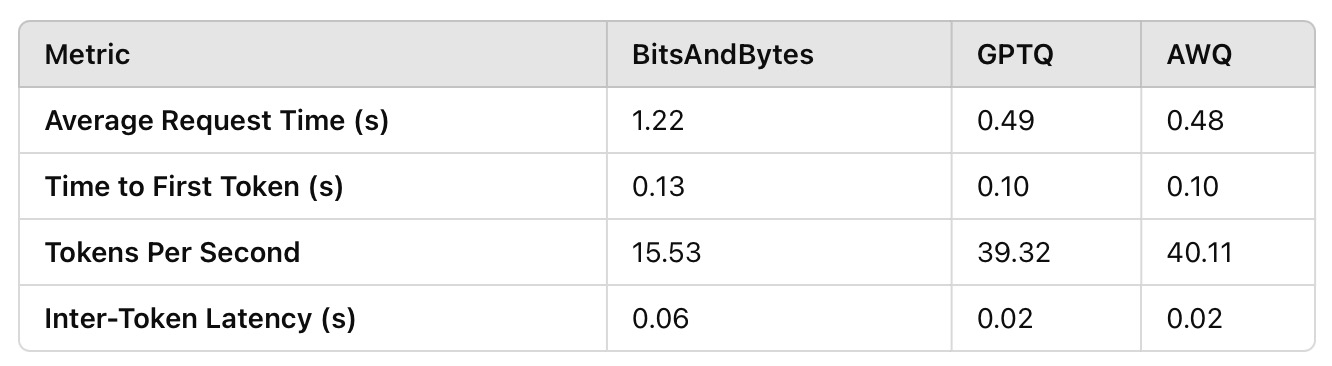

- Speed Improvements: Both GPTQ and AWQ dramatically speed up inference compared to BitsAndBytes. We're talking about cutting the average request time by more than half.

- Token Generation: When it comes to how fast tokens are produced, GPTQ and AWQ are over twice as fast as BitsAndBytes. That's a big deal if you're aiming for responsive applications.

- Smoothness: The lower inter-token latency with GPTQ and AWQ means the responses feel smoother and more immediate, which is great for user experience.

- Minor Differences Between GPTQ and AWQ: While both GPTQ and AWQ offer significant improvements, AWQ has a slight edge in terms of tokens per second and average request time, but the difference is pretty minimal.

## Checkpoint Conversion

For both the AWQ and GPTQ quantization strategies - there exist easy conversion strategies.

We'll go over both of those strategies below.

### Using AutoAWQ to Convert a Model

We'll see in the following step how easy it is to convert a model to AWQ by leveraging AutoAWQ.

First, we'll need a model we wish to convert. We'll stick with Llama 3.1 8B Instruct for demonstration purposes.

We'll start by setting some parameters that will help us define the resultant model:

- `zero-point` - this indicates to use Zero-Point Quantization as our quantization strategy.
  - `q = round((x / scale) + zero_point)`, this quantization strategy allows us to better represent numbers asymetrically around zero, meaning we can use unsigned 8bit integers to describe both positvie and negative weights.
- `q_group_size` - like in BNB quantization, we quantize many weights under the same `scale` and `zero_point` to add additional efficiency during quanitzation without losing as much precision. These are sometimes called "bins" or "blocks".
- `w_bit` - the size of the weight in bits



In [13]:
model_path = "meta-llama/Meta-Llama-3.1-8B-Instruct"
quant_path = "hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4"

quant_config = {
  "zero_point": True,
  "q_group_size": 128,
  "w_bit": 4,
  "version": "GEMM",
}

In [ ]:
from awq import AutoAWQForCausalLM
from transformers import AutoTokenizer

# Load model
model = AutoAWQForCausalLM.from_pretrained(
  model_path, low_cpu_mem_usage=True, use_cache=False, device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Quantize
model.quantize(tokenizer, quant_config=quant_config)

# Save quantized model
model.save_quantized(quant_path)
tokenizer.save_pretrained(quant_path)

print(f'Model is quantized and saved at "{quant_path}"')

### Using GPTQModel to Convert a Model

We'll see in the following step how easy it is to convert a model to GPTQ by leveraging [GPTQModel](https://github.com/ModelCloud/GPTQModel).

First, we'll need a model we wish to convert. We'll stick with Llama 3.1 8B Instruct for demonstration purposes.

We'll start by setting some parameters that will help us define the resultant model:

- `bits` - the target bit width for the final quanitzed model
- `group_size` - the number of weights to be quantized under a single scaling factor

In [ ]:
from gptqmodel import GPTQModel, QuantizeConfig

pretrained_model_dir = "NousResearch/Meta-Llama-3.1-8B-Instruct"
quantized_model_dir = "Meta-Llama-3.1-8B-Instruct-4bit"

quant_config = QuantizeConfig(
    bits=4,
    group_size=128,
)

In [ ]:
import logging

logging.basicConfig(
    format="%(asctime)s %(levelname)s [%(name)s] %(message)s", level=logging.INFO, datefmt="%Y-%m-%d %H:%M:%S"
)

In [ ]:
from transformers import AutoTokenizer, TextGenerationPipeline

# Load model
model = GPTQModel.from_pretrained(pretrained_model_dir, quant_config)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_dir, use_fast=True)
calibration_dataset = [tokenizer(text) for text in test_sentences]

# Quantize
model.quantize(calibration_dataset)

# Save quantized model
model.save_quantized(quantized_model_dir)

print(f'Model is quantized and saved at "{quantized_model_dir}"')

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

WARNING - Calibration dataset size should be greater than 256. Current size: 103.
WARNING - The average length of input_ids of calibration_dataset should be greater than 256: actual avg: 10.320388349514563.
WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.
Quantizing mlp.down_proj in layer 31 of 31: 100%|██████████| 32/32 [09:33<00:00, 17.92s/it]
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'avg_loss': '0.00119', 'damp_percent': '0.00500', 'time': '3.234'}, {'layer': 0, 'module': 'self_attn.v_proj', 'avg_loss': '0.00005', 'damp_percent': '0.00500', 'time': '1.608'}, {'layer': 0, 'module': 'self_attn.q_proj', 'avg_loss': '0.00199', 'damp_percent': '0.00500', 'time': '1.643'}, {'layer': 0, 'module': 'self_attn.o_proj', 'avg_loss': '0.00000', 'damp_percent': '0.00500', 'time': '1.620'}, {'layer': 0, 'module': 'mlp.up_proj', 'avg_loss': '0.00368', 'damp_percent': '0.00

Model is quantized and saved at "Meta-Llama-3.1-8B-Instruct-4bit"


In [ ]:
model = GPTQModel.from_quantized(quantized_model_dir)

INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.


In [ ]:
print(tokenizer.decode(model.generate(**tokenizer("gptqmodel is", return_tensors="pt").to(model.device))[0]))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


<|begin_of_text|>gptqmodel is a Python package for working with the GPT-Q model. It provides
